In [0]:
# ライブラリのインポート
import torch
import torch.nn.functional as f
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
%matplotlib inline

In [0]:
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.STL10('./data', split='train', download=True, transform=transform_train)

testset = datasets.STL10('./data', split='test', download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
# 5000枚
train_loader = DataLoader(
    trainset, batch_size=20, shuffle=True,
    num_workers=4, drop_last=True,
)
# 8000枚
test_loader = DataLoader(
    testset, batch_size=20, shuffle=False,
    num_workers=4, drop_last=False,
)

In [0]:
# 10種類のクラス分類
classes = ('plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

In [0]:
# def imshow(img):
#   img = img / 2 + 0.5
#   npimg = img.numpy()
#   plt.imshow(np.transpose(npimg, (1, 2, 0)))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# imshow(torchvision.utils.make_grid(images))



In [0]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# VGG16を使ってfine-tuning
net = models.vgg16(pretrained=True)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 最後を10種類の分類に変更
net.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

In [0]:
print(net)

In [0]:
import torch.optim as optim
# 損失関数の定義
criterion = nn.CrossEntropyLoss()
# VGG16ではSGDを使う
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

In [0]:
# GPU仕様に変更
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [0]:
# 学習結果の保存用
history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
}

In [0]:
# 学習する
for epoch in range(10):
  running_loss = 0.0
  # 学習開始
  net.train()
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    # GPU仕様に変更
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    # 損失の計算
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.data
    if i % 50 == 49:
      print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 100))
      if (i == 249):
        history['train_loss'].append(float(running_loss / 100))
      running_loss = 0.0


  # テストデータで検証
  net.eval()
  correct = 0
  total = 0
  test_loss = 0
  with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = Variable(images)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

  print('test loss: %.3f' % (test_loss / len(test_loader)))
  print('test Accuracytest: %.3f %%' % (100 * correct / total))
  history['test_loss'].append(float(test_loss / len(test_loader)))
  history['test_acc'].append(float(100 * correct / total))

print('Finished Training')

[1,    50] loss: 0.486
[1,   100] loss: 0.241
[1,   150] loss: 0.196
[1,   200] loss: 0.189
[1,   250] loss: 0.218
test loss: 0.310
test Accuracytest: 89.000 %
[2,    50] loss: 0.105
[2,   100] loss: 0.117
[2,   150] loss: 0.119
[2,   200] loss: 0.139
[2,   250] loss: 0.122
test loss: 0.328
test Accuracytest: 89.000 %
[3,    50] loss: 0.067
[3,   100] loss: 0.060
[3,   150] loss: 0.060
[3,   200] loss: 0.093
[3,   250] loss: 0.090
test loss: 0.278
test Accuracytest: 90.000 %
[4,    50] loss: 0.036
[4,   100] loss: 0.046
[4,   150] loss: 0.055
[4,   200] loss: 0.058
[4,   250] loss: 0.045
test loss: 0.228
test Accuracytest: 92.000 %
[5,    50] loss: 0.019
[5,   100] loss: 0.010
[5,   150] loss: 0.039
[5,   200] loss: 0.049
[5,   250] loss: 0.027
test loss: 0.241
test Accuracytest: 92.000 %
[6,    50] loss: 0.030
[6,   100] loss: 0.023
[6,   150] loss: 0.021
[6,   200] loss: 0.017
[6,   250] loss: 0.033
test loss: 0.369
test Accuracytest: 90.000 %
[7,    50] loss: 0.032
[7,   100] loss: 

In [39]:
correct = 0.0
total = 0.0
for data in test_loader:
    images, labels = data
    images = Variable(images)
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 8000 test images: %3f %%' % float(100 * correct / total))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in test_loader:
    images, labels = data
    images = Variable(images)
    images = images.to(device)
    labels = labels.to(device)
    #print("images type : ", type(images))
    #print("images.shape : ", images.shape)
    # 学習
    outputs = net(images)
    # 一番確率が高いの
    _, predicted = torch.max(outputs.data, 1)
    
    c = (predicted == labels).squeeze()
    for i in range(10):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %3f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 8000 test images: 93.287506 %
Accuracy of plane : 96.323532 %
Accuracy of  bird : 96.560844 %
Accuracy of   car : 94.878052 %
Accuracy of   cat : 90.171989 %
Accuracy of  deer : 92.731827 %
Accuracy of   dog : 82.597404 %
Accuracy of horse : 93.902435 %
Accuracy of monkey : 96.658714 %
Accuracy of  ship : 96.560844 %
Accuracy of truck : 95.320198 %


In [0]:
print(history['train_loss'])
print(history['test_loss'])
print(history['test_acc'])

[0.46968549489974976, 0.27182310819625854, 0.18418288230895996, 0.12257573753595352, 0.1346186101436615, 0.07820197939872742, 0.06016432121396065, 0.11004206538200378, 0.11025169491767883, 0.04223208501935005]
[0.39582667746115474, 0.2702235229747021, 0.3989572367157234, 0.2936181142995338, 0.2847405394556699, 0.2858073176346124, 0.42442666620541786, 0.27229359748416754, 0.36417517143163425, 0.32380789685927086]
[86.0, 90.0, 87.0, 89.0, 90.0, 91.0, 88.0, 91.0, 88.0, 90.0]


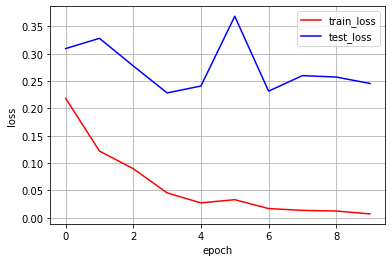

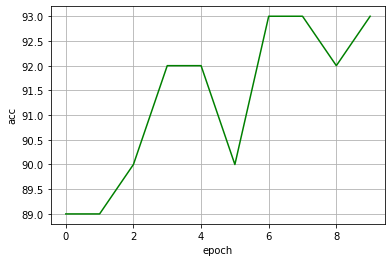

In [0]:
plt.figure()
plt.plot(range(10), history['train_loss'], 'r-', label='train_loss')
plt.plot(range(10), history['test_loss'], 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(10), history['test_acc'], 'g-', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [0]:
PATH = './drive/My Drive/model.pth'
torch.save(net.state_dict(), PATH)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
